# Interactive Mapping 

In [11]:
# Load packages 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.colors as mcolors
import seaborn as sns         
import numpy as np
import os
import folium
import plotly.express as px
import rasterio 
import rioxarray as rioxr
import libpysal as lps 
from libpysal.weights import W 
from esda.getisord import G_Local
# from bokeh.plotting import figure, show

# import libpysal as lps 
# from libpysal.weights import W 
# from esda.getisord import G_Local
# from functions import state_gstar

# Remove max columns
pd.set_option('display.max_columns', None)

In [2]:
# Read in GeoJSON of all 
# national_results = gpd.read_file('/capstone/justice40/data/national_results.geojson')

base_dir = "/capstone/justice40"
# base_dir = "~/MEDS/justice40/data-exploration"

# 2.0 communities files (from current CEJST website)
comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))

# Version 2.0 shapefile data
v2_geo = gpd.read_file(os.path.join(base_dir, "data", "2.0-shapefile-codebook", "usa", "usa.shp"))

/tmp/ipykernel_370253/3449771699.py:8: DtypeWarning: Columns (18,29,73,75,88,134) have mixed types. Specify dtype option on import or set low_memory=False.
  comm_v2 = pd.read_csv(os.path.join(base_dir, "data", "2.0-communities.csv"))


In [3]:
comm_small = comm_v2[['Census tract 2010 ID', 'County Name', 'State/Territory', 'Total threshold criteria exceeded', 'Total categories exceeded', 'Identified as disadvantaged', 'Total population']]

comm_small = comm_small.rename(columns={
    'Census tract 2010 ID': 'tract_id',
    'County Name':'county',
    'State/Territory':'state',
    'Total threshold criteria exceeded':'total_criteria', 
    'Total categories exceeded':'total_burdens', 
    'Identified as disadvantaged':'dac', 
    'Total population':'total_population'
})

In [4]:
# select geographic columns
geo_small = v2_geo[['GEOID10', 'geometry']]

# Change census tract id type so we can merge later on
geo_small = geo_small.rename(columns={'GEOID10':'tract_id'})
geo_small['tract_id'] = geo_small['tract_id'].astype('int64')


# Merge geometry df and burden df
complete = pd.merge(comm_small, geo_small, on='tract_id')
complete = gpd.GeoDataFrame(complete)

complete.head()

,tract_id,county,state,total_criteria,total_burdens,dac,total_population,geometry
0,1001020100,Autauga County,Alabama,0,0.0,False,1993.0,"POLYGON ((-86.48196 32.49876, -86.48189 32.498..."
1,1001020200,Autauga County,Alabama,0,0.0,False,1959.0,"POLYGON ((-86.46828 32.4737, -86.468 32.47371,..."
2,1001020300,Autauga County,Alabama,0,0.0,False,3507.0,"POLYGON ((-86.46538 32.47372, -86.46597 32.473..."
3,1001020400,Autauga County,Alabama,0,0.0,False,3878.0,"POLYGON ((-86.43807 32.45349, -86.43812 32.453..."
4,1001020500,Autauga County,Alabama,0,0.0,False,10596.0,"POLYGON ((-86.4118 32.47416, -86.4118 32.47369..."


In [5]:
# Filter to only continental 48 states
state_names = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

# Took out alaska and hawaii for now
nat_contig = complete[complete['state'].isin(state_names)]

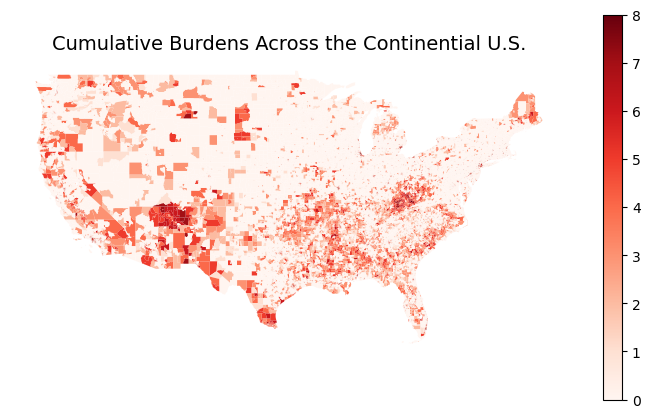

In [ ]:
# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title('Cumulative Burdens Across the Continential U.S.',
            fontsize=14)

# Plot NY state and color by number of spills 
nat_contig.plot(ax=ax,
                column='total_burdens',
                cmap='Reds',
                legend=True, 
                legend_kwds={
                    'label':'Number of Burdens'
                })
plt.show()

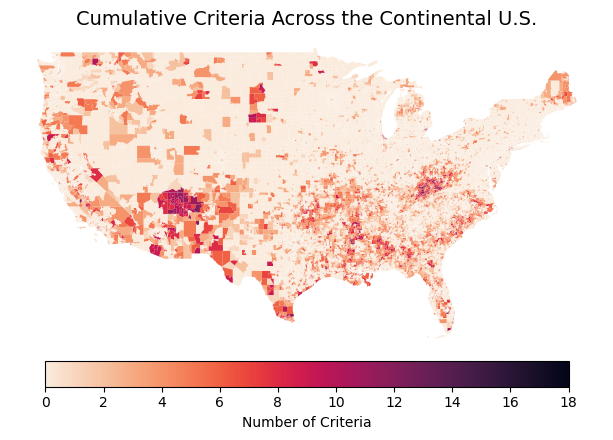

In [28]:
import matplotlib.pyplot as plt

# Initialize figure with transparent background
fig, ax = plt.subplots(figsize=(9,5), facecolor='none')

# Remove axis for a cleaner map and set title with styling
ax.axis('off')
ax.set_title('Cumulative Criteria Across the Continental U.S.',
            fontsize=14, color='black')

# Use the "rocket" colormap from Seaborn
rocket_cmap = sns.color_palette("rocket_r", as_cmap=True)

# Plot the map with improved aesthetics
nat_contig.plot(ax=ax,
                column='total_criteria',
                cmap=rocket_cmap,  # Adjusted colormap for better visibility
                legend=True,
                # edgecolor='black',  # Adds clear state boundaries
                linewidth=0.5,
                legend_kwds={
                    'label': 'Number of Criteria',
                    'orientation': 'horizontal',
                    'pad': 0.02,
                    'shrink': 0.75,  # Shrinks the legend
                })

# Set figure background to transparent
fig.patch.set_alpha(0)  
plt.savefig("add_criteria.png", dpi=300)
plt.show()



In [ ]:
nat_contig

In [8]:
# LISA
# Drop geometry NAs
state_clean = nat_contig[(nat_contig.geometry.type == 'Polygon') |( nat_contig.geometry.type == 'MultiPolygon')]

# Create weights using Queen method 
w = lps.weights.Queen(state_clean['geometry'])

# Run the Getis Ord test for burdens
gstar_burden = G_Local(state_clean['total_burdens'], w, transform='R', permutations=9999) # Set transform=R because the queen weights are row-standardized weights.

# Run the Getis Ord test for criteria
gstar_crit = G_Local(state_clean['total_criteria'], w, transform='R', permutations=9999)

# Add burden stats to to a new df
results = state_clean.drop('tract_id', axis=1).copy()
results['standardized_gstar_burd'] = gstar_burden.Zs 
results['p_norm_burd'] = gstar_burden.p_norm # p-value assuming normal distribution

# Add criteria stats
results['standardized_gstar_crit'] = gstar_crit.Zs 
results['p_norm_crit'] = gstar_crit.p_norm # p-value assuming normal distribution

/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 8 islands with ids: 9855, 10296, 11371, 16267, 32083, 32765, 57701, 57848.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 9855, ' is an island (no neighbors)')
('WARNING: ', 10296, ' is an island (no neighbors)')
('WARNING: ', 11371, ' is an island (no neighbors)')
('WARNING: ', 16267, ' is an island (no neighbors)')
('WARNING: ', 32083, ' is an island (no neighbors)')
('WARNING: ', 32765, ' is an island (no neighbors)')
('WARNING: ', 57701, ' is an island (no neighbors)')
('WARNING: ', 57848, ' is an island (no neighbors)')


/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/hoyler/.conda/envs/justice40-env/lib/python3.10/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


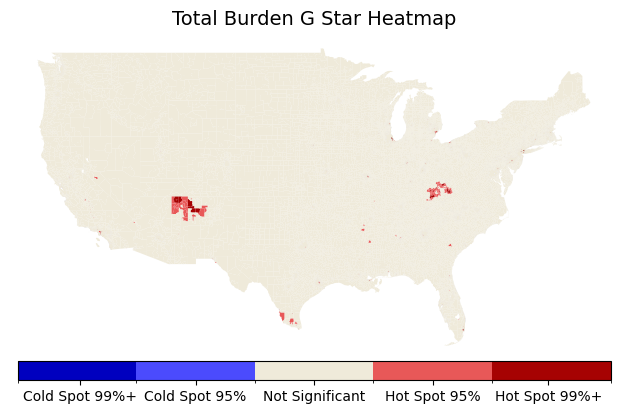

In [20]:
# Define 5 distinct colors
colors = ["#0000bf", "#4b4bfd", "#efeada", "#e85858", "#a60202"]  

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Define color boundaries
bounds = [-3, -2.58, -1.96, 1.96, 2.58, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Remove axis for a cleaner map and set title
ax.axis('off')
ax.set_title(f"Total Burden G Star Heatmap",
            fontsize=14)

# Plot NY state and color by number of spills 
plot = results.plot(ax=ax,
                column='standardized_gstar_burd',
                cmap=cmap,
                norm=norm,
                legend=False)

# Get the colorbar from the plot
cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax, 
orientation='horizontal', pad=0, shrink=0.85, aspect=30)

# # Modify the colorbar tick labels
cbar.set_ticks([-2.78, -2.27, 0, 2.27, 2.78])
cbar.set_ticklabels(['Cold Spot 99%+', 'Cold Spot 95%', 'Not Significant', 'Hot Spot 95%', 'Hot Spot 99%+']) 

plt.show()

In [9]:
results.head()

,county,state,total_criteria,total_burdens,dac,total_population,geometry,standardized_gstar_burd,p_norm_burd,standardized_gstar_crit,p_norm_crit
0,Autauga County,Alabama,0,0.0,False,1993.0,"POLYGON ((-86.48196 32.49876, -86.48189 32.498...",-0.61488,0.269317,-0.559029,0.288071
1,Autauga County,Alabama,0,0.0,False,1959.0,"POLYGON ((-86.46828 32.4737, -86.468 32.47371,...",-0.61488,0.269317,-0.559029,0.288071
2,Autauga County,Alabama,0,0.0,False,3507.0,"POLYGON ((-86.46538 32.47372, -86.46597 32.473...",-0.61488,0.269317,-0.559029,0.288071
3,Autauga County,Alabama,0,0.0,False,3878.0,"POLYGON ((-86.43807 32.45349, -86.43812 32.453...",-0.61488,0.269317,-0.559029,0.288071
4,Autauga County,Alabama,0,0.0,False,10596.0,"POLYGON ((-86.4118 32.47416, -86.4118 32.47369...",-0.61488,0.269317,-0.559029,0.288071


Text(0.5, 1.0, 'Histogram of Total Burdens')

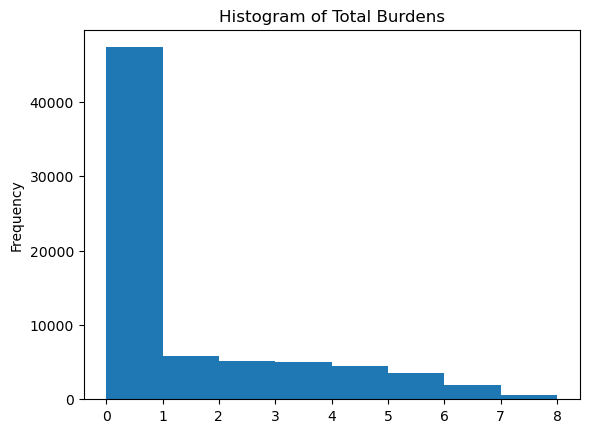

In [7]:
national_results['total_burdens'].plot(kind='hist', bins=8)
plt.title('Histogram of Total Burdens')

Text(0.5, 1.0, 'Histogram of Total Criteria')

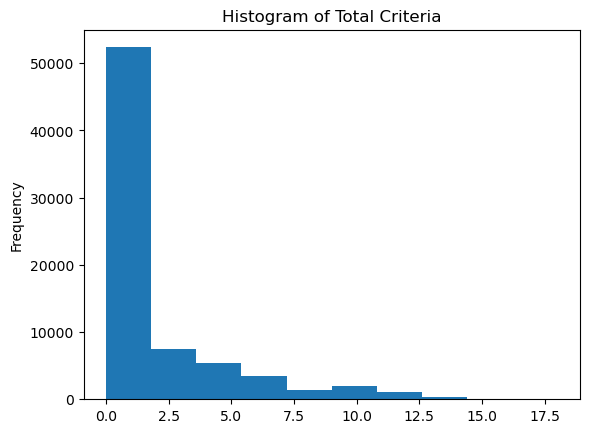

In [5]:
national_results['total_criteria'].plot(kind='hist')
plt.title('Histogram of Total Criteria')

In [4]:
national_results.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
west = -124.848974  # Leftmost longitude (Cape Alava, Washington)
east = -66.947028   # Rightmost longitude (West Quoddy Head, Maine)
south = 24.396308   # Bottommost latitude (Key West, Florida)
north = 49.384358   # Topmost latitude (Northwest Angle, Minnesota)

bbox = [west, south, east, north]  # [min_lon, min_lat, max_lon, max_lat]
# or as
bbox = [[south, west], [north, east]]  # [[min_lat, min_lon], [max_lat, max_lon]]

map = folium.Map()
map.fit_bounds(bbox)
map

In [ ]:
# folium.Choropleth(
#     geo_data=national_results,
#     name="choropleth",
#     data=national_results,
#     columns=["geometry", "standardized_g_star"],
#     key_on="feature.id",  # Changed this line
#     fill_color="RdBu",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name="Standardized G Star",
# ).add_to(map)

# folium.LayerControl().add_to(map)
# map

In [ ]:
# folium.LayerControl().add_to(map)
# map

In [ ]:
# national_small = national_results[['geometry', 'standardized_g_star']]
# national_small = national_small.rename(columns={'standardized_g_star':'stand_gstar'})
# national_small.head()

,geometry,stand_gstar
0,"POLYGON ((-86.48196 32.49876, -86.48189 32.498...",-0.620617
1,"POLYGON ((-86.46828 32.4737, -86.468 32.47371,...",-0.620617
2,"POLYGON ((-86.46538 32.47372, -86.46597 32.473...",-0.620617
3,"POLYGON ((-86.43807 32.45349, -86.43812 32.453...",-0.620617
4,"POLYGON ((-86.4118 32.47416, -86.4118 32.47369...",-0.620617


In [ ]:
# national_small.to_file('/capstone/justice40/data/national_small.geojson', driver="GeoJSON")  

In [ ]:
gstar_test = national_results[['tract_id', 'standardized_g_star']]
gstar_test = gstar_test.rename(columns={'standardized_g_star':'stand_gstar'})
gstar_test.head()

     tract_id  stand_gstar
0  1001020100    -0.620617
1  1001020200    -0.620617
2  1001020300    -0.620617
3  1001020400    -0.620617
4  1001020500    -0.620617


pandas.core.frame.DataFrame

In [ ]:
# gstar_test.to_csv('/capstone/justice40/data/gstar_test.csv', index=False)


LA bbox: -118.642662,33.635306,-117.638567,34.260405
Bay area bbox: -122.527054,37.724125,-122.186404,37.888963
New Orleans: -90.417037,29.752031,-89.823646,30.113637
Chicago: -87.796698,41.770952,-87.563874,41.950359
New York: -74.024549,40.704935,-73.922217,40.847075
